In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from jax import random, jit

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter, sigmasq, get_cutoff_indices

import gwjax
import gwjax.imrphenom

import optax

from jax.config import config
config.update("jax_debug_nans", True)

/mnt/lustre/shared_conda/envs/sgreen/PyCBCandOptuna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Define the conditiion data function
dynfac = 1.0e23
def condition(strain, sampling_rate):
    tmp = resample_to_delta_t(highpass(strain, 15.0), 1.0/sampling_rate).crop(2,2)
    return (dynfac*tmp)

# Define the PSD function 
def estimate_psd(strain, delta_f):
    psd = strain.psd(4)
    psd = interpolate(psd, delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * strain.sample_rate),
                                  low_frequency_cutoff=15, trunc_method='hann')
    return psd

# Define the matched filter function
def matched_filter(signal_duration, sampling_rate, kmin, kmax, fcore, template): 
    workspace = jnp.zeros(int(sampling_rate*signal_duration), dtype=complex) 
    result_fft = fcore * jnp.conjugate(template) 
    workspace = workspace.at[kmin:kmax].set(result_fft)
    result = jnp.fft.ifft(workspace)
    result *= len(result)
    return result

# Define the waveform template function
def waveform_template(freqs, m1, m2, s1, s2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': s1, 'spin2': s2,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

# Define sigma squared function 
def sigma_squared(delta_freq, invpsd, template):
    weighted_inner = jnp.sum(template*jnp.conj(template)*invpsd)
    h_norm = 4*delta_freq
    sigma_squared = jnp.real(weighted_inner)*h_norm
    #print(f'sigma_squared {sigma_squared}')
    return sigma_squared

# Define the waveform template function
def optuna_waveform_template(freqs, m1, m2):
    params = {'phase': 0., 'geocent_time': 0.,
            'luminosity_distance': 1, 'theta_jn': 0., 
            'm1': m1, 'm2': m2, 'spin1': 0, 'spin2': 0,
            'ra': 0., 'dec': 0., 'pol': 0.}
    # Create the waveform template using the mass parameters
    # Adjust this function based on your specific waveform model
    #may want to do partial on this
    return gwjax.imrphenom.IMRPhenomD(freqs, params)

def snr(invpsd, delta_freq, sampling_rate, matched_output, sigma_squared_output):
    norm = 4*delta_freq / jnp.sqrt(sigma_squared_output)
    snr = matched_output*norm
    snr_min = int((2+4)*sampling_rate)
    snr_max = len(snr)-int((2)*sampling_rate)
    snr = snr[snr_min:snr_max]
    peak = jnp.argmax(jnp.absolute(snr))
    snrp = jnp.absolute(snr[peak])
    return(snrp)


# Define the objective function to minimize (negative SNR)
def objective(params):
    m1, m2, s1, s2 = params
    template, _ = my_waveform_template(m1, m2, s1, s2)
    #print(template)
    matched_output = my_matched_filter(template)
    #print(matched_output)
    sigma_squared_output = my_sigma_squared(template)
    #print(sigma_squared_output)
    snr_peak = my_snr(matched_output, sigma_squared_output)
    #print(snr_peak)
    return -snr_peak

In [3]:
# Get the data and estimate the PSDs
merger = Merger("GW150914")
sampling_rate = 2048 # Sampling rate in Hz
data = condition(merger.strain('H1'), sampling_rate)
signal_duration = float(data.duration)  # Duration of the signal in seconds
delta_freq = data.delta_f

invpsd = estimate_psd(data, data.delta_f)**(-1)

fcore = data.to_frequencyseries()*invpsd

#Get the frequency range
nyquist = sampling_rate//2
freqs = jnp.arange(1+(nyquist*signal_duration))/signal_duration


#Determine the low freq and high frequency cut off
kmin, kmax = int(15*signal_duration), int(900*signal_duration)

#Make everything the same length
data = jnp.array([data.to_frequencyseries()[kmin:kmax]])
fcore = jnp.asarray(fcore[kmin:kmax])
freqs = freqs[kmin:kmax]
invpsd = jnp.asarray(invpsd[kmin:kmax]) # can't take fft because it needs to start at 0 to nyquist 

In [4]:
def loglikelihood_fn(params, *_):
    m1, m2 = params
    parameters = {'phase': 0., 
              'geocent_time': 0., 
              'luminosity_distance': 1, 
              'theta_jn': 0., 
              'm1': m1, 'm2': m2, 
              'spin1': 0., 'spin2': 0., 
              'ra': 0., 'dec': 0., 
              'pol': 0.}
    hp, hc = gwjax.imrphenom.IMRPhenomD(freqs, parameters)
    d_inner_h = 0.
    optimal_snr_squared = 0.
    fp = -0.456852978678261
    fc = 0.36204310587763466
    h = hp*fp + hc*fc
    h_star = jnp.conj(h)
    integrand = jnp.nan_to_num(h_star * data * invpsd, 0.)
    d_inner_h += 4.0 / 32.0 * jnp.sum(integrand)
    integrand = jnp.nan_to_num(h_star * h * invpsd, 0.)
    optimal_snr_squared += (4.0 / 32.0 * jnp.sum(integrand)).real
    log_l = d_inner_h.real - optimal_snr_squared / 2
    return log_l.real

In [5]:
loglikelihood_fn([30.0, 30.0])

Array(26.42207181, dtype=float64)

In [6]:
from typing import NamedTuple

class ScheduleState(NamedTuple):
    step_size: float
    do_sample: bool


def build_schedule(
    num_training_steps,
    num_cycles=4,
    initial_step_size=1e-3,
    exploration_ratio=0.25,
):
    cycle_length = num_training_steps // num_cycles

    def schedule_fn(step_id):
        do_sample = False
        if ((step_id % cycle_length)/cycle_length) >= exploration_ratio:
            do_sample = True

        cos_out = jnp.cos(jnp.pi * (step_id % cycle_length) / cycle_length) + 1
        step_size = 0.5 * cos_out * initial_step_size

        return ScheduleState(step_size, do_sample)

    return schedule_fn

Text(0.5, 1.0, 'Training schedule for Cyclical SGLD')

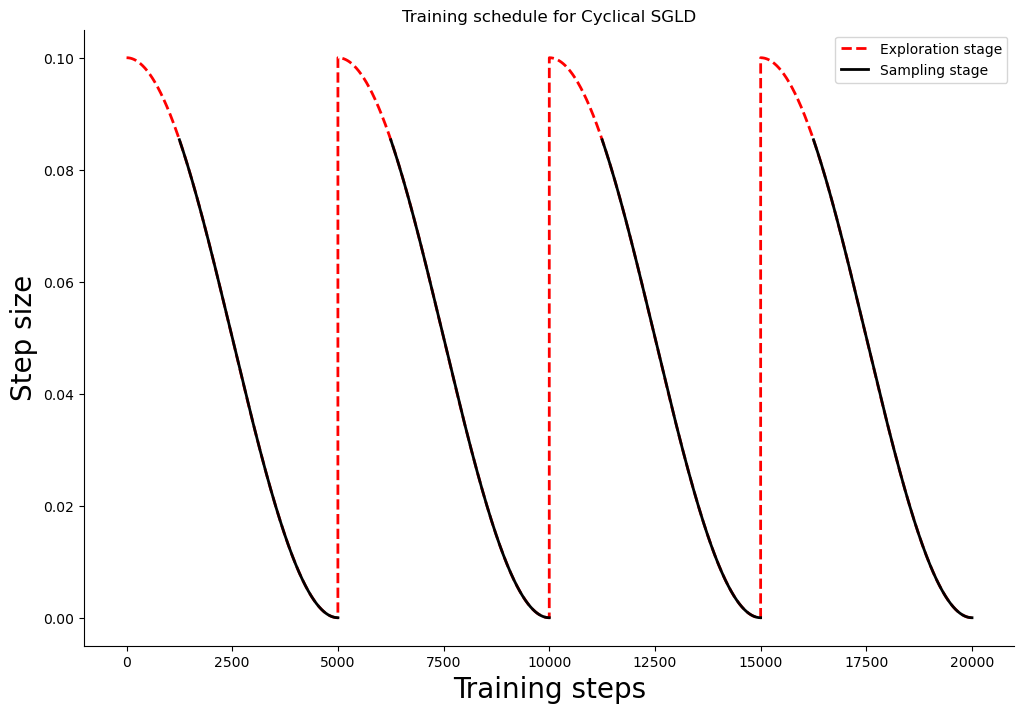

In [7]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

schedule_fn = build_schedule(20000, 4, 1e-1)
schedule = [schedule_fn(i) for i in range(20000)]

step_sizes = np.array([step.step_size for step in schedule])
do_sample = np.array([step.do_sample for step in schedule])

sampling_points = np.ma.masked_where(~do_sample, step_sizes)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(step_sizes, lw=2, ls="--", color="r", label="Exploration stage")
ax.plot(sampling_points, lw=2, ls="-", color="k", label="Sampling stage")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_xlabel("Training steps", fontsize=20)
ax.set_ylabel("Step size", fontsize=20)
plt.legend()
plt.title("Training schedule for Cyclical SGLD")

In [8]:
from typing import NamedTuple

import blackjax
import optax

from jax.tree_util import tree_structure
from optax._src.base import OptState


class CyclicalSGMCMCState(NamedTuple):
    """State of the Cyclical SGMCMC sampler.
    """
    position: tree_structure
    opt_state: OptState


def cyclical_sgld(grad_estimator_fn, loglikelihood_fn):

    # Initialize the SgLD step function
    sgld = blackjax.sgld(grad_estimator_fn)
    sgd = optax.sgd(1.)

    def init_fn(position):
        opt_state = sgd.init(position)
        print(CyclicalSGMCMCState(position, opt_state))
        return CyclicalSGMCMCState(position, opt_state)

    def step_fn(rng_key, state, minibatch, schedule_state):
        """Cyclical SGLD kernel."""

        def step_with_sgld(current_state):
            rng_key, state, minibatch, step_size = current_state
            new_position = sgld.step(rng_key, state.position, minibatch, step_size)
            print(new_position)
            return CyclicalSGMCMCState(new_position, state.opt_state)

        def step_with_sgd(current_state):
            _, state, minibatch, step_size = current_state
            grads = grad_estimator_fn(state.position, 0)
            print(f'the {grads}')
            rescaled_grads = - 1. * step_size * grads
            updates, new_opt_state = sgd.update(rescaled_grads, state.opt_state, state.position)
            new_position = optax.apply_updates(state.position, updates)
            print(f'the sgd new position {new_position}')
            return CyclicalSGMCMCState(new_position, new_opt_state)

        new_state = jax.lax.cond(
            schedule_state.do_sample,
            step_with_sgld,
            step_with_sgd,
            (rng_key, state, minibatch, schedule_state.step_size)
        )

        return new_state

    return init_fn, step_fn

In [9]:
import jax
from fastprogress import progress_bar


# 50k iterations
# M = 30
# initial step size = 0.09
# ratio exploration = 1/4
num_training_steps = 5000
schedule_fn = build_schedule(num_training_steps, 30, 0.09, 0.25)
#print(schedule_fn)
schedule = [schedule_fn(i) for i in range(num_training_steps)]
#print(schedule)
grad_fn = lambda x, _: jax.grad(loglikelihood_fn)(x)

#def grad_fn(x, *args):
 #   return jax.grad(loglikelihood_fn)(x)

init, step = cyclical_sgld(grad_fn, loglikelihood_fn)

rng_key = jax.random.PRNGKey(3)
init_position = jnp.array([30.0, 30.0])
print(init_position)
init_state = init(init_position)


state = init_state
cyclical_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    state = jax.jit(step)(rng_key, state, 0, schedule[i])
    if schedule[i].do_sample:
        cyclical_samples.append(state.position)

[30. 30.]
CyclicalSGMCMCState(position=Array([30., 30.], dtype=float64), opt_state=(EmptyState(), EmptyState()))


Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=2/0)>
the Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=2/0)>
the sgd new position Traced<ShapedArray(float64[2])>with<DynamicJaxprTrace(level=2/0)>


Text(0.5, 1.0, 'Trajectory with Cyclical SGLD')

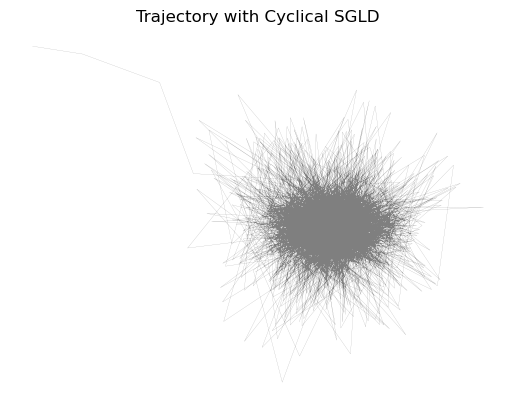

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [sample[0] for sample in cyclical_samples]
y = [sample[1] for sample in cyclical_samples]

ax.plot(x, y, 'k-', lw=0.1, alpha=0.5)

plt.axis('off')
plt.title("Trajectory with Cyclical SGLD")

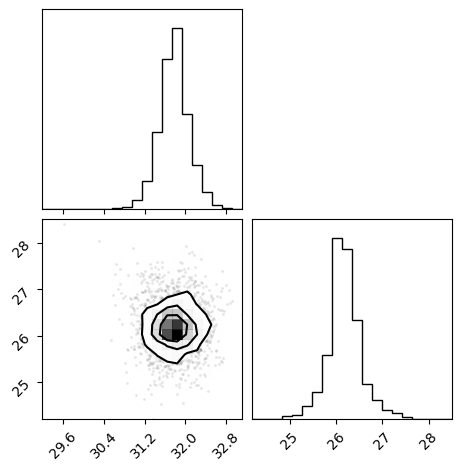

In [15]:
import corner

figure = corner.corner(np.array([cyclical_samples]))